# Best Photo Selection

*   With better synthetic data filters.


## Giving a score for how good or bad a photograph is.

### Using [Flickr Image dataset](https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset)

Train data is based on:

*   7000 good photos.
*   7000 synthetic bad photos, generated from the other photos in the Flickr Image dataset.

### Step 0: Load Kaggle Datasets Directly into Google Colab

Upload the kaggle.json file (an API token) to the colab (Follow this [article](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/) to see how to do that) and run the following code:

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.15G/8.16G [00:38<00:00, 295MB/s]
100% 8.16G/8.16G [00:38<00:00, 227MB/s]


In [7]:
! unzip flickr-image-dataset.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/f

### Step 1: Generating bad photos from good photos

#### Choosing images from a folder

In [8]:
# loading libraries
import cv2
import numpy as np
import os, random
from PIL import Image, ImageDraw

In [9]:
def choose_photos(filename, n_photos=-1):
    if isinstance(filename, list):
        photos = filename
    else:
        photos = os.listdir(folder)
    if n_photos == -1:
        return photos
    number_files = len(photos)
    if number_files < n_photos:
        return 'number of photos is larger than the photos in the folder/set'
    chosen_photos = photos[:n_photos]
    photos = photos[n_photos:]
    return photos, chosen_photos

In [10]:
folder = r"/content/flickr30k_images/flickr30k_images/flickr30k_images"
photos = choose_photos(folder)

In [11]:
len(photos)

31783

#### Creating "good" and "bad" folders

##### train dataset

In [12]:
try:
    os.mkdir('train') 
except OSError as error: 
    print(error)

In [13]:
try:
    os.mkdir('train/good') 
except OSError as error: 
    print(error)

In [14]:
try:
    os.mkdir('train/bad')
except OSError as error: 
    print(error)

##### test dataset

In [15]:
try:
    os.mkdir('test') 
except OSError as error: 
    print(error)

In [16]:
try:
    os.mkdir('test/good') 
except OSError as error: 
    print(error)

In [17]:
try:
    os.mkdir('test/bad') 
except OSError as error: 
    print(error)

#### Copying the random chosen images into the "good" folder

In [18]:
import shutil

##### train set

In [19]:
photos, good_photos = choose_photos(photos, 7000)

In [20]:
print('Chosen photos:', len(good_photos))
print('Remaining number of photos:', len(photos))
bool(set(photos) & set(good_photos))

Chosen photos: 7000
Remaining number of photos: 24783


False

In [21]:
for photo in good_photos:
    shutil.copy(folder + '/' + photo, 'train/good')

##### test set

In [22]:
photos, good_photos = choose_photos(photos, 700)

In [23]:
print('Chosen photos:', len(good_photos))
print('Remaining number of photos:', len(photos))
bool(set(photos) & set(good_photos))

Chosen photos: 700
Remaining number of photos: 24083


False

In [24]:
for photo in good_photos:
    shutil.copy(folder + '/' + photo, 'test/good')

#### Generating bad photos with filters

In [25]:
# motion blur filter
#size - in pixels, size of motion blur
#angle - in degrees, direction of motion blur
def apply_motion_blur(image, size, angle):
    k = np.zeros((size, size), dtype=np.float32)
    k[ (size-1)// 2 , :] = np.ones(size, dtype=np.float32)
    k = cv2.warpAffine(k, cv2.getRotationMatrix2D( (size / 2 -0.5 , size / 2 -0.5 ) , angle, 1.0), (size, size) )
    k = k * (1.0 / np.sum(k))
    return cv2.filter2D(image, -1, k)

In [26]:
# random gaussian blur outer circle filter
def random_blur_out(image, radius=100):
    img_size = (image.shape[0], image.shape[1], 3)
    blurred_img = cv2.GaussianBlur(image, (21, 21), 0)
    mask = np.zeros(img_size, dtype=np.uint8)
    x, y = (random.randint(0, img_size[0]-radius), random.randint(0, img_size[1]-radius))
    mask = cv2.circle(mask, (x, y), radius, (255, 255, 255), -1)
    return np.where(mask==np.array([255, 255, 255]), image, blurred_img)

In [27]:
# random gaussian blur inner circle filter
def random_blur_in(image, radius):
    img_size = (image.shape[0], image.shape[1], 3)
    blurred_img = cv2.GaussianBlur(image, (21, 21), 0)
    mask = np.zeros(img_size, dtype=np.uint8)
    x, y = (random.randint(0, img_size[0]-radius), random.randint(0, img_size[1]-radius))
    mask = cv2.circle(mask, (x, y), radius, (255, 255, 255), -1)
    return np.where(mask==np.array([0, 0, 0]), image, blurred_img)

In [28]:
# distance between two points (a and b)
def distance(a,b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

# return true/false if a point (c) is between two points (a and b)
def is_between(a,c,b):
    return distance(a,c) + distance(c,b) == distance(a,b)

# random gaussian semi-blur filter
def random_semi_blur(image):
    img_size = (image.shape[0], image.shape[1], 3)
    blurred_img = cv2.GaussianBlur(image, (21, 21), 0)
    mask = np.zeros(img_size, dtype=np.uint8)
    x_start, y_start = random.choice([(random.randint(0, img_size[0]), 0), (0, random.randint(0, img_size[1]))])
    x_end, y_end = (img_size[1] - x_start, img_size[0] - y_start)
    mask = cv2.line(mask, (x_start, y_start), (x_end, y_end), (255, 255, 255), 1)
    while True:
        seed = (random.randint(0, img_size[1]), random.randint(0, img_size[0]))
        if not is_between((x_start, y_start), seed, (x_end, y_end)):
            break
    rep_value = (255, 255, 255)
    mask = Image.fromarray(mask)
    ImageDraw.floodfill(mask, seed, rep_value, thresh=50)
    mask = np.asarray(mask)
    return np.where(mask==np.array([255, 255, 255]), image, blurred_img)

In [29]:
# illumination filter
def adjust_gamma(image, gamma=0.5):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [30]:
import requests
lens_flare_urls = ['https://raw.githubusercontent.com/EranPer/lens_flare/main/lens%20flare/lens-flare-png-46213.png',
                   'https://raw.githubusercontent.com/EranPer/lens_flare/main/lens%20flare/lens-flare-png-46228.png',
                   'https://raw.githubusercontent.com/EranPer/lens_flare/main/lens%20flare/lightsource.png',
                   'https://raw.githubusercontent.com/EranPer/lens_flare/main/lens%20flare/lightsource2.png',
                   'https://raw.githubusercontent.com/EranPer/lens_flare/main/lens%20flare/lightsource3.png']

# lens flare filter
def lens_flare(image, size=1, lens_flare_folder=lens_flare_urls):
    
    # load random lens flare layer from url
    url = random.choice(lens_flare_urls)
    lightsource = Image.open(requests.get(url, stream=True).raw)

    # load random lens flare layer from folder (with files)
    # lens_flare_folder='lens flare/'
    # files = os.listdir(lens_flare_folder)
    # lightsource = Image.open(lens_flare_folder + random.choice(files))
    
    # resize to input image size
    lightsource_size = (int(image.shape[1]*size), int(image.shape[0]*size))
    lightsource = lightsource.resize(lightsource_size)
    lightsource = Image.fromarray(np.uint8(lightsource))
    
    # Open Front Image
    frontImage = lightsource
    
    # Flip the light source layer Vertical & Horizontal randomly (or not)
    frontImage = random.choice([frontImage.transpose(Image.FLIP_LEFT_RIGHT), frontImage])
    frontImage = random.choice([frontImage.transpose(Image.FLIP_TOP_BOTTOM), frontImage])
    
    # Open Background Image
    background = Image.fromarray(np.uint8(image))

    # Convert image to RGBA
    frontImage = frontImage.convert("RGBA")

    # Convert image to RGBA
    background = background.convert("RGBA")

    # Calculate width to be at the center
    width = (background.width - frontImage.width) // 2

    # Calculate height to be at the center
    height = (background.height - frontImage.height) // 2

    # Paste the frontImage at (width, height)
    background.paste(frontImage, (width, height), frontImage)
    
    return np.asarray(background)

In [31]:
# random noise filter
def add_noise(image):
    mean = 0.0   # some constant
    std = 127.5    # some constant (standard deviation)
    noisy_img = image + np.random.normal(mean, std, (image.size[1], image.size[0], 3))
    noisy_img_clipped = np.clip(noisy_img, 0, 255)  # we might get out of bounds due to noise
    return noisy_img_clipped

In [32]:
def apply_filter(image, filter_name='motion_blur'):
    if filter_name == 'motion_blur':
        return apply_motion_blur(image, 10, 90)
    if filter_name == 'random_blur_out':
        return random_blur_out(image, radius=100)
    if filter_name == 'random_blur_in':
        return random_blur_in(image, radius=100)
    if filter_name == 'random_semi_blur':
        return random_semi_blur(image)
    if filter_name == 'bright':
        return adjust_gamma(image, 6)
    if filter_name == 'dark':
        return adjust_gamma(image, 0.3)
    if filter_name == 'flare':
        return lens_flare(image)
    if filter_name == 'noise':
        return add_noise(image)
    if filter_name == 'mix_1':
        return adjust_gamma(apply_motion_blur(lens_flare(image), 10, 90), 6)
    if filter_name == 'mix_2':
        return adjust_gamma(apply_motion_blur(lens_flare(image), 10, 90), 0.3)

##### train set

In [33]:
filters = ['motion_blur', 'bright', 'dark', 'flare', 'loss', 'mix_1', 'mix_2']
counter = dict()
total = 0

n_filtered_images = 1000
for fil in filters:
    counter[fil] = 0
    photos, chosen_photos_to_be_filtered = choose_photos(photos, n_filtered_images)
    for img_file in chosen_photos_to_be_filtered:
        if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
          break
        img = Image.open(folder + '/' + img_file).convert('RGB')
        img = np.array(img) 
        img = img[:, :, ::-1].copy()
        if fil != 'loss':
            cv2.imwrite('train/bad/' + img_file[:-4] + '_' + fil + '.jpg', apply_filter(img, filter_name=fil))
        else:
            # low quality filter (jpeg loss)
            # The image quality, on a scale from 1 (worst) to 95 (best).
            # The default is 75. Values above 95 should be avoided;
            # 100 disables portions of the JPEG compression algorithm, and results in large files with hardly any gain in image quality.
            quality_val = 5
            img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            Image.fromarray(img).save('train/bad/' + img_file[:-4] + '_' + fil + '.jpg', 'JPEG', quality=quality_val)
        counter[fil] += 1
    print('Generated ' + str(counter[fil]) + ' for the ' + fil + ' filter')
    total += counter[fil]
print('Generated total of ' + str(total) + ' bad images')

Generated 1000 for the motion_blur filter
Generated 1000 for the bright filter
Generated 1000 for the dark filter
Generated 1000 for the flare filter
Generated 1000 for the loss filter
Generated 1000 for the mix_1 filter
Generated 1000 for the mix_2 filter
Generated total of 7000 bad images


##### test set

In [34]:
counter = dict()
total = 0

n_filtered_images = 100
for fil in filters:
    counter[fil] = 0
    photos, chosen_photos_to_be_filtered = choose_photos(photos, n_filtered_images)
    for img_file in chosen_photos_to_be_filtered:
        img = Image.open(folder + '/' + img_file).convert('RGB')
        img = np.array(img) 
        img = img[:, :, ::-1].copy()
        if fil != 'loss':
            cv2.imwrite('test/bad/' + img_file[:-4] + '_' + fil + '.jpg', apply_filter(img, filter_name=fil))
        else:
            # low quality filter (jpeg loss)
            # The image quality, on a scale from 1 (worst) to 95 (best).
            # The default is 75. Values above 95 should be avoided;
            # 100 disables portions of the JPEG compression algorithm, and results in large files with hardly any gain in image quality.
            quality_val = 5
            img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            Image.fromarray(img).save('test/bad/' + img_file[:-4] + '_' + fil + '.jpg', 'JPEG', quality=quality_val)
        counter[fil] += 1
    print('Generated ' + str(counter[fil]) + ' for the ' + fil + ' filter')
    total += counter[fil]
print('Generated total of ' + str(total) + ' bad images')

Generated 100 for the motion_blur filter
Generated 100 for the bright filter
Generated 100 for the dark filter
Generated 100 for the flare filter
Generated 100 for the loss filter
Generated 100 for the mix_1 filter
Generated 100 for the mix_2 filter
Generated total of 700 bad images


### Step 2: Data preparation

In [35]:
from keras.preprocessing.image import ImageDataGenerator
img_gen = ImageDataGenerator(validation_split=0.2)

In [36]:
train_data = img_gen.flow_from_directory(
    'train/',
    class_mode='binary',
    batch_size=64,
    target_size=(224, 224),
    subset='training',
)

Found 11200 images belonging to 2 classes.


In [37]:
valid_data = img_gen.flow_from_directory(
    'train/',
    class_mode='binary',
    batch_size=64,
    target_size=(224, 224),
    subset='validation',
)

Found 2800 images belonging to 2 classes.


In [38]:
print('there are 11200 images in the training set and', len(train_data), 'mini-batches')
print('there are 2800 images in the validation set and', len(valid_data), 'mini-batches')

there are 11200 images in the training set and 175 mini-batches
there are 2800 images in the validation set and 44 mini-batches


### Step 3: A baseline model using a VGG16 model (CNN)

In [39]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [40]:
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.1 MB/s 


In [41]:
import tensorflow

In [42]:
import efficientnet.keras as efn

In [43]:
import tensorflow
vgg_model = tensorflow.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3))

258088960/258076736 [==============================] - 2s 0us/step


In [44]:
print('there are', len(vgg_model.layers), 'layers in vgg_model')
print('there are', vgg_model.count_params(), 'parameters in vgg_model')

there are 813 layers in vgg_model
there are 64097687 parameters in vgg_model


In [45]:
print('input shape is', vgg_model.input_shape)
print('output shape is', vgg_model.output_shape)
vgg_model.summary()

input shape is (None, 224, 224, 3)
output shape is (None, 7, 7, 2560)
Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad 

In [46]:
from tensorflow import keras
from tensorflow.keras import layers

In [47]:
x = vgg_model.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
# x = layers.Dense(1024, activation="relu")(x)
# x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
predictions = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs = vgg_model.input, outputs = predictions)

In [48]:

""""
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential(
    vgg_model.layers + 
    [
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)
model.summary()

"""""

'"\nfrom tensorflow import keras\nfrom tensorflow.keras import layers\nmodel = keras.Sequential(\n    vgg_model.layers + \n    [\n        \n        layers.Flatten(),\n        layers.Dense(128, activation=\'relu\'),\n        layers.Dense(1, activation=\'sigmoid\')\n    ]\n)\nmodel.summary()\n\n'

In [49]:
vgg_model.trainable=False

In [50]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [51]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [52]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.fit(train_data, validation_data=valid_data, batch_size=16, steps_per_epoch=len(train_data), validation_steps=len(valid_data), epochs=10, callbacks=[cp_callback])

Epoch 1/10
175/175 [==============================] - ETA: 0s - loss: 0.7196 - accuracy: 0.7321
Epoch 1: saving model to training_1/cp.ckpt
175/175 [==============================] - 207s 919ms/step - loss: 0.7196 - accuracy: 0.7321 - val_loss: 0.5131 - val_accuracy: 0.7682
Epoch 2/10
175/175 [==============================] - ETA: 0s - loss: 0.3682 - accuracy: 0.8385
Epoch 2: saving model to training_1/cp.ckpt
175/175 [==============================] - 156s 892ms/step - loss: 0.3682 - accuracy: 0.8385 - val_loss: 0.4528 - val_accuracy: 0.8014
Epoch 3/10
175/175 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.8889
Epoch 3: saving model to training_1/cp.ckpt
175/175 [==============================] - 156s 892ms/step - loss: 0.2722 - accuracy: 0.8889 - val_loss: 0.4878 - val_accuracy: 0.8054
Epoch 4/10
175/175 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9299
Epoch 4: saving model to training_1/cp.ckpt
175/175 [==========================

In [54]:
os.listdir(checkpoint_dir)

['cp.ckpt.data-00000-of-00001', 'checkpoint', 'cp.ckpt.index']

#### Pickling the model

In [55]:
import pickle
pickle.dump(model, open('training_1/model_EfficientNetB7.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://80d94450-2044-4484-88ac-4abbe0b96fe2/assets


#### Zip the model and train data and download the files to local computer

In [56]:
!zip -r /content/model.zip /content/training_1
!zip -r /content/train.zip /content/train
!zip -r /content/test.zip /content/test

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  adding: content/train/good/6906541132.jpg (deflated 0%)
  adding: content/train/good/1370773415.jpg (deflated 0%)
  adding: content/train/good/1387461595.jpg (deflated 0%)
  adding: content/train/good/247691240.jpg (deflated 0%)
  adding: content/train/good/5016926064.jpg (deflated 0%)
  adding: content/train/good/4413446289.jpg (deflated 0%)
  adding: content/train/good/4814948204.jpg (deflated 0%)
  adding: content/train/good/3336808362.jpg (deflated 3%)
  adding: content/train/good/49695755.jpg (deflated 0%)
  adding: content/train/good/126438084.jpg (deflated 0%)
  adding: content/train/good/1126137905.jpg (deflated 1%)
  adding: content/train/good/3392851587.jpg (deflated 0%)
  adding: content/train/good/4754577090.jpg (deflated 4%)
  adding: content/train/good/4493628129.jpg (deflated 0%)
  adding: content/train/good/2701487024.jpg (deflated 0%)
  adding: content/train/good/3614595423.jpg (deflated 0%)
  adding:

In [57]:
from google.colab import files
files.download("/content/model.zip")
files.download("/content/train.zip")
files.download("/content/test.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Step 4: testing the model

In [58]:
threshold = 0.5

In [59]:
test_data = img_gen.flow_from_directory(
    'test/',
    target_size=(224, 224),
    class_mode=None,
    shuffle=False,
)

Found 1400 images belonging to 2 classes.


In [60]:
pred = model.predict_generator(generator=test_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [61]:
y_true = test_data.classes
y_pred = pred > threshold

#### Confusion matrix

In [62]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_true, y_pred)

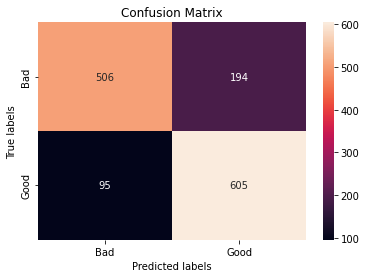

In [63]:
import seaborn as sns
from matplotlib import pyplot as plt

ax = plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Bad', 'Good']); ax.yaxis.set_ticklabels(['Bad', 'Good']);

#### Classification report

In [64]:
from sklearn.metrics import classification_report
target_names = ['bad', 'good']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         bad       0.84      0.72      0.78       700
        good       0.76      0.86      0.81       700

    accuracy                           0.79      1400
   macro avg       0.80      0.79      0.79      1400
weighted avg       0.80      0.79      0.79      1400



#### Evaluating samples of test data

In [65]:
def evaluate(img_fname):
    img = image.load_img(img_fname, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)[0][0]
    pred_class = 'good' if pred > threshold else 'bad'
    pred = pred if pred_class == 'good' else 1 - pred
    print('Predicted:', pred_class, 'with prediction (confidence) of ' + str(round(pred, 3)))
    plt.imshow(img)
    plt.show()

Predicted: good with prediction (confidence) of 0.989


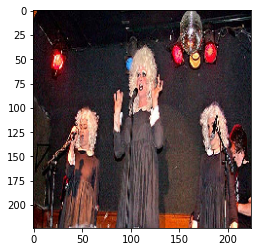

Predicted: good with prediction (confidence) of 0.752


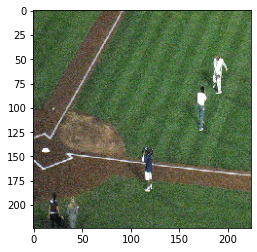

Predicted: good with prediction (confidence) of 0.574


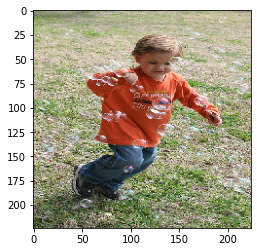

Predicted: bad with prediction (confidence) of 0.965


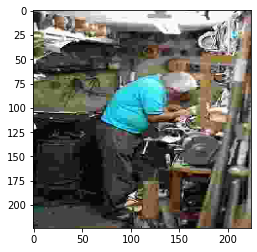

Predicted: good with prediction (confidence) of 0.909


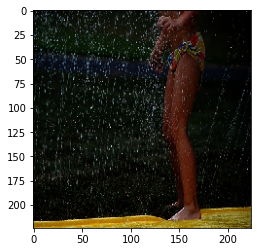

Predicted: good with prediction (confidence) of 0.955


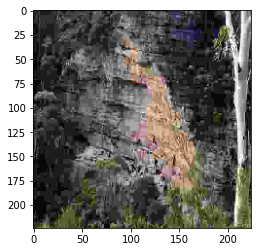

Predicted: good with prediction (confidence) of 0.932


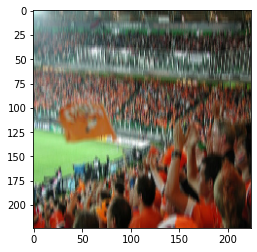

Predicted: good with prediction (confidence) of 1.0


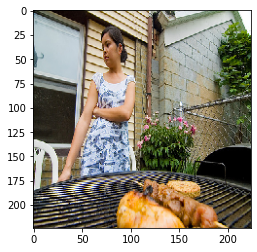

Predicted: good with prediction (confidence) of 1.0


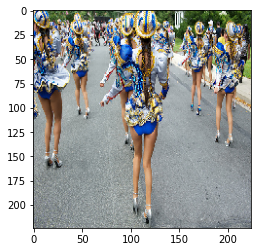

Predicted: bad with prediction (confidence) of 0.994


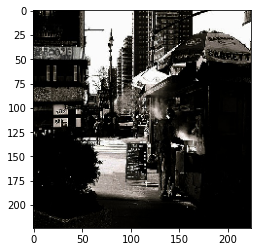

In [66]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import random

for img in random.sample(test_data.filenames, 10):
    evaluate('test/' + str(img))